Inspired/based on https://github.com/rayidghani/magicloops

In [2]:
import pipeline_v2 as pipeline
import importlib
import datetime
import pandas as pd
import numpy as np

# Read data

In [3]:
importlib.reload(pipeline)

data = pipeline.read_csv('projects_2012_2013.csv')

Reading file...
Done


# Explore data

Data exploration...

Number of rows: 124976

Columns and types of data:
projectid                                  object
teacher_acctid                             object
schoolid                                   object
school_ncesid                             float64
school_latitude                           float64
school_longitude                          float64
school_city                                object
school_state                               object
school_metro                               object
school_district                            object
school_county                              object
school_charter                             object
school_magnet                              object
teacher_prefix                             object
primary_focus_subject                      object
primary_focus_area                         object
secondary_focus_subject                    object
secondary_focus_area                       object
resource_type               

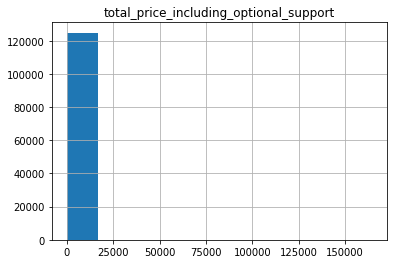

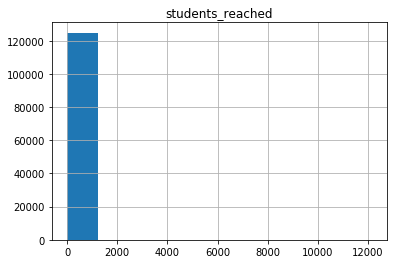

In [4]:
importlib.reload(pipeline)

stats_for_variables = [
  'total_price_including_optional_support',
  'students_reached'
]

variables_for_correlation = [
  'total_price_including_optional_support',
  'students_reached'
]

pipeline.explore_data(data, stats_for_variables, variables_for_correlation)



We can clearly see in the histograms that DebtRadio MontlyIncome have very big outliers.

# Process data

In [5]:
importlib.reload(pipeline)

columns_to_process = [
  'total_price_including_optional_support',
  'students_reached'
]

data = pipeline.pre_process_data(data, columns_to_process)

# Datafram withou na values?
True if sum(data.isna().any()) == 0 else False

Pre processing data...
Done


False

# Create discrete features and select predictors

In [6]:
importlib.reload(pipeline)

cols_to_transform = [
'school_state',
'school_metro',
'school_charter',
'school_magnet',
'primary_focus_subject',
'primary_focus_area',
'resource_type',
'poverty_level',
'grade_level',
'eligible_double_your_impact_match']


data = pipeline.create_dummies(data, cols_to_transform)

In [7]:
selected_features = ['school_state_AK','school_state_AL','school_state_AR','school_state_AZ','school_state_CA','school_state_CO','school_state_CT','school_state_DC','school_state_DE','school_state_FL','school_state_GA','school_state_HI','school_state_IA','school_state_ID','school_state_IL','school_state_IN','school_state_KS','school_state_KY','school_state_LA','school_state_MA','school_state_MD','school_state_ME','school_state_MI','school_state_MN','school_state_MO','school_state_MS','school_state_MT','school_state_NC','school_state_ND','school_state_NE','school_state_NH','school_state_NJ','school_state_NM','school_state_NV','school_state_NY','school_state_OH','school_state_OK','school_state_OR','school_state_PA','school_state_RI','school_state_SC','school_state_SD','school_state_TN','school_state_TX','school_state_UT','school_state_VA','school_state_VT','school_state_WA','school_state_WI','school_state_WV','school_state_WY','school_state_nan','school_metro_rural','school_metro_suburban','school_metro_urban','school_metro_nan','school_charter_f','school_charter_t','school_charter_nan','school_magnet_f','school_magnet_t','school_magnet_nan','primary_focus_subject_Applied Sciences','primary_focus_subject_Character Education','primary_focus_subject_Civics & Government','primary_focus_subject_College & Career Prep','primary_focus_subject_Community Service','primary_focus_subject_ESL','primary_focus_subject_Early Development','primary_focus_subject_Economics','primary_focus_subject_Environmental Science','primary_focus_subject_Extracurricular','primary_focus_subject_Foreign Languages','primary_focus_subject_Gym & Fitness','primary_focus_subject_Health & Life Science','primary_focus_subject_Health & Wellness','primary_focus_subject_History & Geography','primary_focus_subject_Literacy','primary_focus_subject_Literature & Writing','primary_focus_subject_Mathematics','primary_focus_subject_Music','primary_focus_subject_Nutrition','primary_focus_subject_Other','primary_focus_subject_Parent Involvement','primary_focus_subject_Performing Arts','primary_focus_subject_Social Sciences','primary_focus_subject_Special Needs','primary_focus_subject_Sports','primary_focus_subject_Visual Arts','primary_focus_subject_nan','primary_focus_area_Applied Learning','primary_focus_area_Health & Sports','primary_focus_area_History & Civics','primary_focus_area_Literacy & Language','primary_focus_area_Math & Science','primary_focus_area_Music & The Arts','primary_focus_area_Special Needs','primary_focus_area_nan','resource_type_Books','resource_type_Other','resource_type_Supplies','resource_type_Technology','resource_type_Trips','resource_type_Visitors','resource_type_nan','poverty_level_high poverty','poverty_level_highest poverty','poverty_level_low poverty','poverty_level_moderate poverty','poverty_level_nan','grade_level_Grades 3-5','grade_level_Grades 6-8','grade_level_Grades 9-12','grade_level_Grades PreK-2','grade_level_nan','eligible_double_your_impact_match_f','eligible_double_your_impact_match_t','eligible_double_your_impact_match_nan']

# Create binary variable

In [8]:
importlib.reload(pipeline)

# The task is to predict if a project on donorschoose will not get fully funded within 60 days of posting.

# Change dates to date format
data['datefullyfunded_formated'] = pd.to_datetime(data['datefullyfunded'])
data['date_posted_formated'] = pd.to_datetime(data['date_posted'])

In [9]:
importlib.reload(pipeline)

from dateutil.relativedelta import relativedelta

#Calculate difference between two dates
data['time_to_fund'] = data['datefullyfunded_formated'].sub(data['date_posted_formated'], axis=0)


In [10]:
importlib.reload(pipeline)

data['time_to_fund'] = pd.to_numeric(data['time_to_fund'] / np.timedelta64(1, 'D'))
data['funded_in_60'] = np.where(data['time_to_fund']<61, 1, 0)

outcome ='funded_in_60'


# Create train and test sets

In [27]:
data['date_posted_formated'].describe()

count                  124976
unique                    731
top       2012-09-30 00:00:00
freq                      728
first     2012-01-01 00:00:00
last      2013-12-31 00:00:00
Name: date_posted_formated, dtype: object

In [29]:
data.head()

,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_district,school_county,teacher_prefix,...,grade_level_Grades 9-12,grade_level_Grades PreK-2,grade_level_nan,eligible_double_your_impact_match_f,eligible_double_your_impact_match_t,eligible_double_your_impact_match_nan,datefullyfunded_formated,date_posted_formated,time_to_fund,funded_in_60
0,00001ccc0e81598c4bd86bacb94d7acb,96963218e74e10c3764a5cfb153e6fea,9f3f9f2c2da7edda5648ccd10554ed8c,1.709930e+11,41.807654,-87.673257,Chicago,Pershing Elem Network,Cook,Mrs.,...,0,1,0,1,0,0,2013-05-02,2013-04-14,18.0,1
1,0000fa3aa8f6649abab23615b546016d,2a578595fe351e7fce057e048c409b18,3432ed3d4466fac2f2ead83ab354e333,6.409801e+10,34.296596,-119.296596,Ventura,Ventura Unif School District,Ventura,Mrs.,...,0,0,0,0,1,0,2012-04-18,2012-04-07,11.0,1
2,000134f07d4b30140d63262c871748ff,26bd60377bdbffb53a644a16c5308e82,dc8dcb501c3b2bb0b10e9c6ee2cd8afd,6.227100e+10,34.078625,-118.257834,Los Angeles,Los Angeles Unif Sch Dist,Los Angeles,Ms.,...,0,0,0,1,0,0,2012-04-15,2012-01-30,76.0,0
3,0001f2d0b3827bba67cdbeaa248b832d,15d900805d9d716c051c671827109f45,8bea7e8c6e4279fca6276128db89292e,3.600090e+11,40.687286,-73.988217,Brooklyn,New York City Dept Of Ed,Kings (Brooklyn),Ms.,...,0,1,0,1,0,0,2012-12-05,2012-10-11,55.0,1
4,0004536db996ba697ca72c9e058bfe69,400f8b82bb0143f6a40b217a517fe311,fbdefab6fe41e12c55886c610c110753,3.606870e+11,40.793018,-73.205635,Central Islip,Central Islip Union Free SD,Suffolk,Mrs.,...,0,1,0,1,0,0,2013-03-25,2013-01-08,76.0,0


In [68]:
importlib.reload(pipeline)

start_time = '2012-01-01'
end_time = '2013-12-31'
prediction_window = 6
date_column='date_posted_formated'


sets = pipeline.create_temp_validation_train_and_testing_sets(data, 
                                                                   selected_features,
                                                                   outcome,
                                                                   start_time,
                                                                   end_time,
                                                                   prediction_window,
                                                                   date_column)

x_train = sets[0]
x_test = sets[1]
y_train = sets[2]
y_test = sets[3]



In [71]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
# print(y_train.shape)
# print(y_test.shape)

# print(x_train.shape)
# print(x_test.shape)
# print(y_train.shape)
# print(y_test.shape)

(80800, 118)
(80800,)


# Build Clasifiers and parameters generation

In [13]:
importlib.reload(pipeline)

#We define the specific models we want to run
models_to_run=['KNN']#,'DT','LR','SVM','AB','RF','BA']

#Get all posible models and their different sets of parameters
models, parameters_grid = pipeline.get_models_and_parameters()

# Loop over models

In [ ]:
importlib.reload(pipeline)

pipeline.iterate_over_models(models_to_run, models, parameters_grid, x_train, x_test, y_train, y_test)


# DEBUGGING

In [27]:
importlib.reload(pipeline)
pipeline.generate_binary_at_k([0.9,0.8,0.5,0.1,0],60)


[0.9, 0.8, 0.5, 0.1, 0]
60
3
[1, 1, 1, 0, 0]


[1, 1, 1, 0, 0]

In [44]:
importlib.reload(pipeline)

y_pred_scores = [0.4,0.7,0.1]
y_test = [1,1,0]
print(y_pred_scores)
print(y_test)
print("\n")

print(zip(y_pred_scores, y_test))

print(sorted(zip(y_pred_scores, y_test), reverse=True))
print(*sorted(zip(y_pred_scores, y_test), reverse=True))
print(zip(sorted(zip(y_pred_scores, y_test), reverse=True)))
print(*zip(sorted(zip(y_pred_scores, y_test), reverse=True)))

y_pred_scores_sorted, y_test_sorted = zip(*sorted(zip(y_pred_scores, y_test), reverse=True))


y_scores, y_true = pipeline.joint_sort_descending(np.array(y_pred_scores), np.array(y_test))

print(y_scores)
print(y_true)

[0.4, 0.7, 0.1]
[1, 1, 0]


[(0.7, 1), (0.4, 1), (0.1, 0)]
(0.7, 1) (0.4, 1) (0.1, 0)
((0.7, 1),) ((0.4, 1),) ((0.1, 0),)
[0.7 0.4 0.1]
[1 1 0]
